In [1]:
import numpy as np
from scipy.stats import entropy
from scipy.stats import norm
from scipy.special import rel_entr
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

## Source: https://towardsdatascience.com/kl-divergence-python-example-b87069e4b810

## Helpers

In [2]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def kl_divergence_bits(p, q):
    return np.sum(np.where(p != 0, p * np.log2(p / q), 0))

## Examples

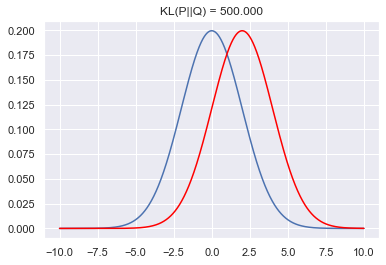

In [3]:
x = np.arange(-10, 10, 0.001)
p = norm.pdf(x, 0, 2)
q = norm.pdf(x, 2, 2)
plt.title('KL(P||Q) = %1.3f' % kl_divergence(p, q))
plt.plot(x, p)
plt.plot(x, q, c='red')

In [4]:
#using scipy
sum(rel_entr(p, q))

499.99971706534797

In [5]:
kl_divergence_bits(p, q)

721.3471122560642

## Jensen-Shannon divergence

In [6]:
# calculate the js divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [7]:
js_divergence(p, q)

111.41111513125573

In [8]:
#is symmetric
js_divergence(q, p)

111.41111513125573

## Fiddle with components

In [9]:
p

array([7.43359757e-07, 7.45220389e-07, 7.47085490e-07, ...,
       7.48955072e-07, 7.47085490e-07, 7.45220389e-07])

In [10]:
q

array([3.03794142e-09, 3.04706855e-09, 3.05622234e-09, ...,
       6.73177347e-05, 6.71832758e-05, 6.70490686e-05])

In [11]:
p/q

array([2.44691932e+02, 2.44569617e+02, 2.44447363e+02, ...,
       1.11256725e-02, 1.11201111e-02, 1.11145524e-02])

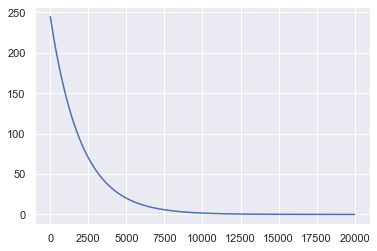

In [12]:
plt.plot(p/q)

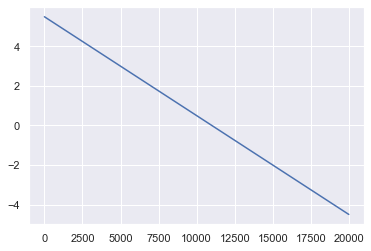

In [13]:
plt.plot(np.log(p / q))

## Relation eith cross-entropy

In [14]:
#https://stats.stackexchange.com/questions/265966/why-do-we-use-kullback-leibler-divergence-rather-than-cross-entropy-in-the-t-sne/265989
p_norm=p/p.sum()
q_norm=q/q.sum()

In [15]:
kl_divergence(p_norm, q_norm)

0.49996887082217045

In [16]:
def cross_entropy(y,y_pre):
    loss=-np.sum(y*np.log(y_pre))
    return loss

In [17]:
#relation between cross-entropy and kl-divergence
cross_entropy(p_norm,q_norm)-entropy(p_norm)

0.499968870822169

ELBO

https://mpatacchiola.github.io/blog/2021/01/25/intro-variational-inference.html

https://www.ritchievink.com/blog/2019/09/16/variational-inference-from-scratch/

In [22]:
import numpy as np
import torch
from torch import nn
from sklearn import datasets
import matplotlib.pyplot as plt

w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    y = (y - y.mean()) / y.std()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    return y[:, None], x[:, None]

Y, X = load_dataset()

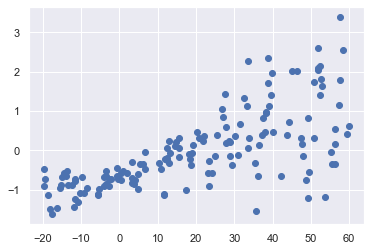

In [29]:
plt.scatter(X, Y)

In [23]:
# Go to pytorch world
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

class MaximumLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.out = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        return self.out(x)
    
epochs = 200
m = MaximumLikelihood()
optim = torch.optim.Adam(m.parameters(), lr=0.01)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = m(X)
    loss = (0.5 * (y_pred - Y)**2).mean()
    loss.backward()
    optim.step()

In [24]:
class VI(nn.Module):
    def __init__(self):
        super().__init__()

        self.q_mu = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.q_log_var = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def reparameterize(self, mu, log_var):
        # std can not be negative, thats why we use log variance
        sigma = torch.exp(0.5 * log_var) + 1e-5
        eps = torch.randn_like(sigma)
        return mu + sigma * eps

    def forward(self, x):
        mu = self.q_mu(x)
        log_var = self.q_log_var(x)
        return self.reparameterize(mu, log_var), mu, log_var

In [25]:
def ll_gaussian(y, mu, log_var):
    sigma = torch.exp(0.5 * log_var)
    return -0.5 * torch.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2))* (y-mu)**2

In [26]:
def elbo(y_pred, y, mu, log_var):
    # likelihood of observing y given Variational mu and sigma
    likelihood = ll_gaussian(y, mu, log_var)
    
    # prior probability of y_pred
    log_prior = ll_gaussian(y_pred, 0, torch.log(torch.tensor(1.)))
    
    # variational probability of y_pred
    log_p_q = ll_gaussian(y_pred, mu, log_var)
    
    # by taking the mean we approximate the expectation
    return (likelihood + log_prior - log_p_q).mean()

def det_loss(y_pred, y, mu, log_var):
    return -elbo(y_pred, y, mu, log_var)

In [27]:
epochs = 1500

m = VI()
optim = torch.optim.Adam(m.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = det_loss(y_pred, Y, mu, log_var)
    loss.backward()
    optim.step()

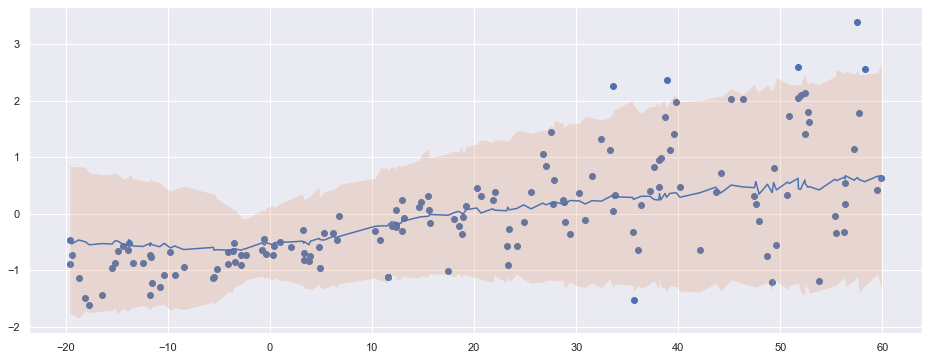

In [28]:
# draw samples from Q(theta)
with torch.no_grad():
    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

plt.figure(figsize=(16, 6))
plt.scatter(X, Y)
plt.plot(X, mu)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2)